<a href="https://colab.research.google.com/github/daRoyalCacti/Stat3007-project/blob/main/Tr_CNN_directly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-processing done**

**To better understand transfer learning, imagine we only have limited SVHN training set at hand without the extra data images. Then this is the test accuracy of the CNN if we directly trained on the SVHN training dataset, which only has around 18.59% true accuracy**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from collections import Counter       #Written by Jacob and used to calculate the true accuracy.
import numpy as np


# actual accuracy
def get_accuracy(p_data, t_data, extra_data):
    sc = 0
    if extra_data is None:
        for i in range(len(p_data)):
            if p_data[i] == t_data[i]:
                sc += 1

        return sc / len(p_data)
    else:
        counter = -1
        for i in range(len(extra_data)):
            is_good = True
            for j in range(extra_data[i]):
                counter += 1
                is_good &= p_data[counter] == t_data[counter]
            if is_good:
                sc += 1
        return sc / len(extra_data)

CNN



In [ ]:
import os

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 5             # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 100
LR = 0.001              # learning rate

In [ ]:
import os
import time
import h5py
import numpy as np

In [ ]:
# Open the file as readonly
h5f = h5py.File('/content/drive/MyDrive/Resizedata_bugfixed.h5', 'r')

# Load the training, test and validation set
x_train = h5f['x_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['x_test'][:]
y_test = h5f['y_test'][:]
x_extra = h5f['x_extra'][:]
y_extra = h5f['y_extra'][:]
# Close this file
h5f.close()

print(x_test.shape)
print(x_train.shape)
print(x_extra.shape)

(26032, 28, 28)
(73257, 28, 28)
(531131, 28, 28)


In [ ]:
x_train = x_train.reshape(len(x_train),1,28,28)
x_test = x_test.reshape(len(x_test),1,28,28)
x_train = x_train/255
x_test = x_test/255
print(x_train.shape)
print(x_test.shape)

(73257, 1, 28, 28)
(26032, 1, 28, 28)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)


In [ ]:
train_dataset = MyDataset(x_train, y_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)

In [ ]:
test_dataset = MyDataset(x_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
)
test_dataiter = iter(test_loader)

In [ ]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
model = CNN()

In [ ]:
optimizer = torch.optim.Adam(model.out.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()       

In [ ]:
for epoch in range(EPOCH):
    
    running_loss = 0.0
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = model(b_x)[0]            # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        running_loss += loss.item()
        
        if step % 1000 == 999:
            images, labels = test_dataiter.next()
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()
            accuracy = float((pred_y == labels.data.numpy()).astype(int).sum()) / float(labels.size(0))
            print('Epoch: ', epoch+1, '|step: ',step, '| train loss: %.4f' % running_loss, '| test accuracy: %.4f' % accuracy)
            running_loss = 0.0

Epoch:  1 |step:  999 | train loss: 2192.8611 | test accuracy: 0.2812
Epoch:  2 |step:  999 | train loss: 2082.0276 | test accuracy: 0.2188
Epoch:  3 |step:  999 | train loss: 1996.0666 | test accuracy: 0.3438
Epoch:  4 |step:  999 | train loss: 1920.5485 | test accuracy: 0.4375
Epoch:  5 |step:  999 | train loss: 1858.4103 | test accuracy: 0.2188


In [ ]:
test_loader2 = DataLoader(
    test_dataset,
    batch_size=26032,
    shuffle=False,
)

In [ ]:
for image, labels in test_loader2:
  pred_y = torch.max(model(image)[0], 1)[1].data.squeeze().numpy()
  accuracy = float((pred_y == labels.data.numpy()).astype(int).sum()) / float(labels.size(0))
print('The test set one-accuracy is:', accuracy)

The test set one-accuracy is: 0.38971266133988935


In [ ]:
for image, labels in test_loader2:
  pred_y = torch.max(model(image)[0], 1)[1].data.squeeze().numpy()

In [ ]:
file = open("/content/drive/MyDrive/cf/test_labels.txt", "r")
stringList = file.readlines()
extra_data = []
for i in range(len(stringList)):
  extra_data.append(len(stringList[i])-1)

In [ ]:
print('The test set true-accuracy is:',get_accuracy(pred_y,y_test,extra_data))

The test set true-accuracy is: 0.18587389041934496


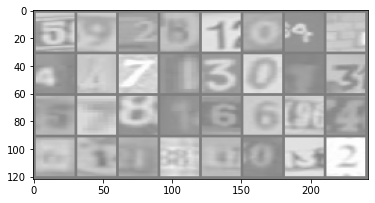

GroundTruth:  tensor(5) tensor(9) tensor(2) tensor(8) tensor(1) tensor(0) tensor(4) tensor(1) tensor(4) tensor(4) tensor(7) tensor(1) tensor(3) tensor(0) tensor(7) tensor(3) tensor(5) tensor(7) tensor(8) tensor(1) tensor(6) tensor(6) tensor(9) tensor(4) tensor(6) tensor(1) tensor(1) tensor(8) tensor(4) tensor(0) tensor(3) tensor(2)


In [ ]:
images, labels = test_dataiter.next()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(32)))

In [ ]:
test_output, last_layer = model(images)
pred_y = torch.max(test_output, 1)[1].data.squeeze().numpy()

print('Predicted: ', ' '.join('%5s' % pred_y[j]
                              for j in range(32)))

Predicted:      5     2     2     1     1     2     2     1     4     1     7     1     5     2     1     4     1     2     5     1     6     5     1     1     2     1     1     1     1     1     4     2
